In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport src

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from src.operators import MeasurementOperator, MeasurementOperatorDiscrete
from src.uv_sampling import RadialSampling, SpiderSampling, SpiderSampling2
from src.solvers import l1_constrained_solver, l1_unconstrained_solver, wavelet_basis

imshow_kwargs = {"cmap":'afmhot', "origin":'lower'}

In [4]:
x_true = fits.getdata("../data/M51.fits")
x_true /= x_true.max()

In [5]:
Nd=(256,256) # input image size 
Kd=(512,512) # oversampled k-space size
Jd=(6,6) # interpolation kernel size

vis = SpiderSampling2() # using Duncan et al. configuration

op_nufft8 = MeasurementOperator(vis, Nd, Kd, (8,8)) # for measurements
op_nufft4 = MeasurementOperator(vis, Nd, Kd, (4,4)) # for reconstruction


## Generating noisy data

In [6]:
y = op_nufft8.dir_op(x_true) # measurements using J=8

In [48]:
# creating noisy data
ISNR = 50 # very low noise
sigma = np.linalg.norm(y, ord=2)/ np.sqrt(len(y)) * 10**(- ISNR/20)

noisy_y = y + np.random.randn(len(y))*np.exp(1j* np.random.random()*2*np.pi )*sigma


Text(0.5, 1.0, 'difference w/ and w/o noise')

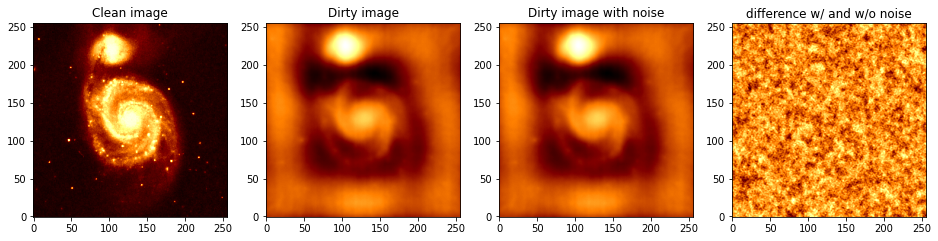

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
ax[0].imshow(x_true, **imshow_kwargs)
ax[0].set_title("Clean image")
ax[1].imshow(op_nufft4.adj_op(y).real, **imshow_kwargs)
ax[1].set_title("Dirty image")
ax[2].imshow(op_nufft4.adj_op(noisy_y).real, **imshow_kwargs)
ax[2].set_title("Dirty image with noise")
ax[3].imshow(op_nufft4.adj_op(y).real - op_nufft4.adj_op(noisy_y).real, **imshow_kwargs)
ax[3].set_title("difference w/ and w/o noise")


## solving with constrained solver

In [61]:
options={'tol': 1e-5, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': False, 'real': False}

result2, diag2 = l1_constrained_solver(noisy_y, op_nufft4, sigma, options=options) # solver is hardcoded for n

2021-03-26 14:07:19,644 - Optimus Primal - INFO - Starting Power method
2021-03-26 14:07:19,688 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-26 14:07:19,890 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-26 14:07:20,095 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-26 14:07:20,213 - Optimus Primal - INFO - [Power Method] Converged with iter = 27, tol = 0.000965014
2021-03-26 14:07:20,308 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-26 14:07:20,422 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.000000
2021-03-26 14:07:25,884 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.015743
2021-03-26 14:07:31,404 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.014386
2021-03-26 14:07:37,104 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.008136
2021-03-26 14:07:42,638 - Optimus Primal - INFO - 

### Results 

Text(0.5, 1.0, 'Residuals (RMSE:4.1760e-02)')

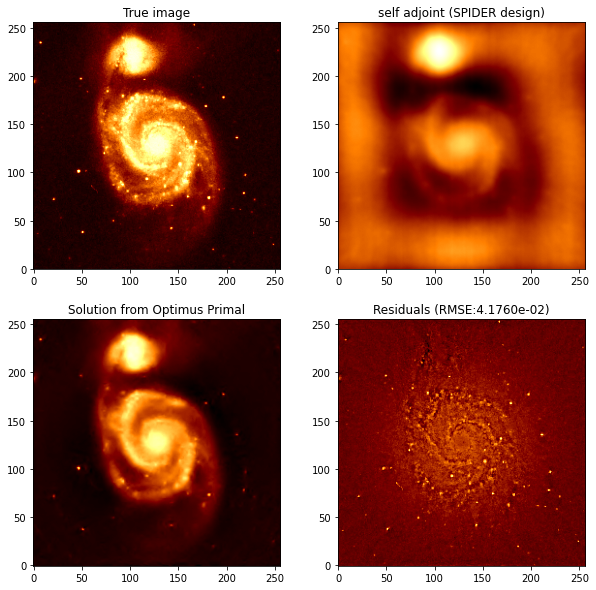

In [64]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result2.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result2.real))):.4e})")


### Analysing optimisation

Text(0.5, 0, 'iterations')

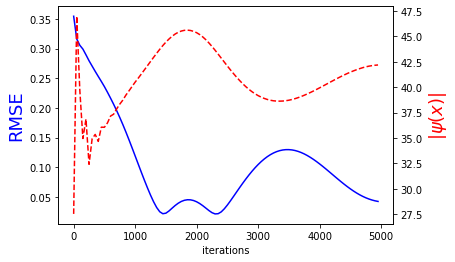

In [65]:
hs = diag2['hs']
xs = np.array(diag2['xs']) 

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

It moves away from the minimum instead of converging. The local minimum looks like this:

Text(0.5, 1.0, 'Residuals (RMSE:2.1390e-02)')

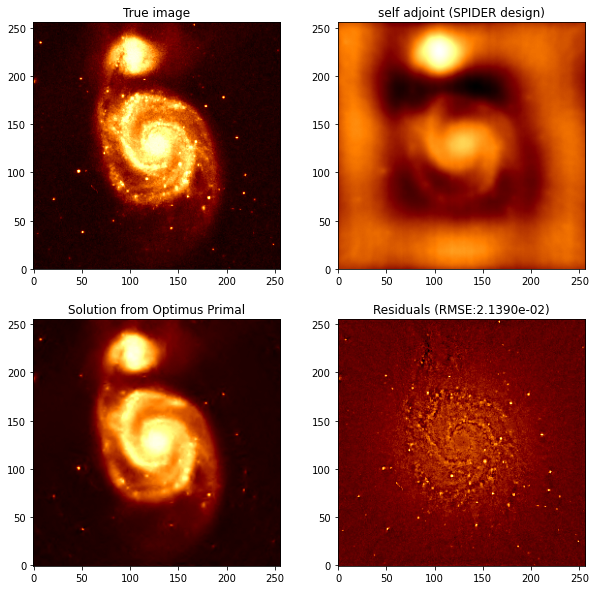

In [27]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

## solving with unconstrained solver

In [49]:
options={'tol': 1e-5, 'iter': 5000, 'update_iter': 50, 'record_iters': False, 'positivity': False, 'real': False}
result3, diag3 = l1_unconstrained_solver(noisy_y, op_nufft4, sigma, options=options) # solver is hardcoded for n

2021-03-26 13:38:45,725 - Optimus Primal - INFO - Starting Power method
2021-03-26 13:38:45,767 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-03-26 13:38:45,973 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-03-26 13:38:46,169 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2021-03-26 13:38:46,287 - Optimus Primal - INFO - [Power Method] Converged with iter = 27, tol = 0.000965014
2021-03-26 13:38:46,370 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-03-26 13:38:46,483 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.214635
2021-03-26 13:38:52,180 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.002958
2021-03-26 13:38:57,623 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.001816
2021-03-26 13:39:03,172 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.001435
2021-03-26 13:39:08,593 - Optimus Primal - INFO - 

### Results

Text(0.5, 1.0, 'Residuals (RMSE:3.0234e-01)')

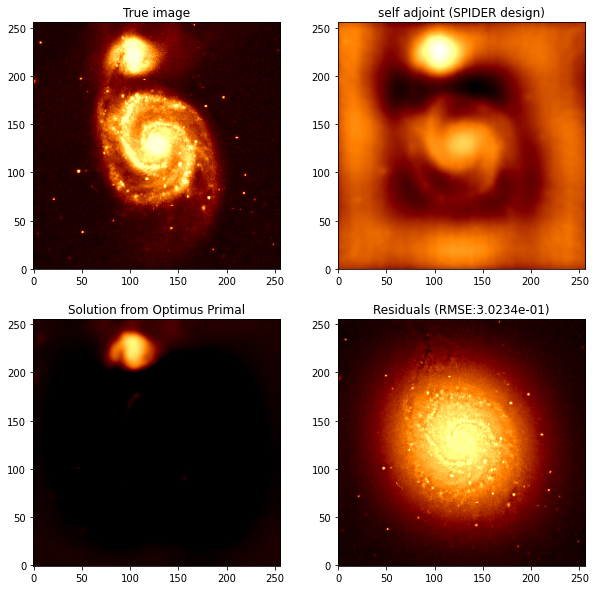

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(result3.real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result3.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - result3.real))):.4e})")

### Analysing optimisation path

Text(0.5, 0, 'iterations')

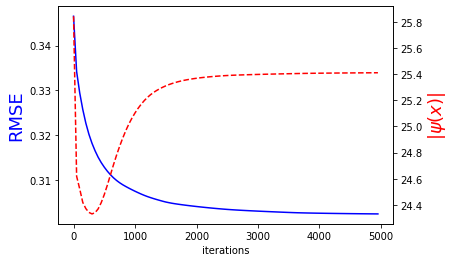

In [51]:
hs = diag3['hs']
xs = np.array(diag3['xs']) 
fs = diag3['fs']

rms = [np.sqrt(np.mean(np.square(x_true - xs[i].real))) for i in range(len(xs))]

fig,ax = plt.subplots()
ax.plot(np.arange(0,5000, 50)[:len(rms)], rms, 'b-')
# ax.plot(np.arange(0,5000, 50)[:len(fs)], fs, 'b-')

ax.set_ylabel('RMSE', color='b', fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.arange(0,5000, 50)[:len(rms)], hs, 'r--')
ax2.set_ylabel(r"$|\psi(x)|$", color='r', fontsize=18)
ax.set_xlabel('iterations')

# plt.axis(xmin = 200)

Text(0.5, 1.0, 'Residuals (RMSE:3.0235e-01)')

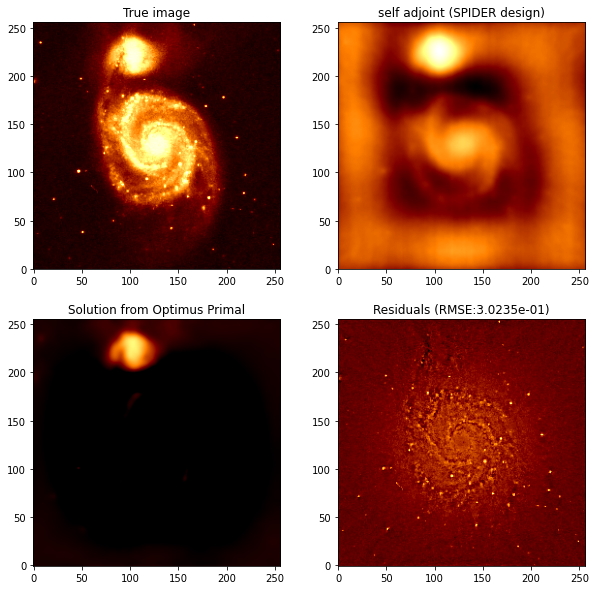

In [52]:
i=np.argmin(rms)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
a = ax[0,0].imshow(x_true, **imshow_kwargs)
ax[0,0].set_title("True image")

lim = a.get_clim()

ax[0,1].imshow(op_nufft4.self_adj(x_true).real, **imshow_kwargs)
ax[0,1].set_title("self adjoint (SPIDER design)")

ax[1,0].imshow(xs[i].real, vmin=lim[0], vmax=lim[1], **imshow_kwargs)
ax[1,0].set_title("Solution from Optimus Primal")

ax[1,1].imshow(x_true - result2.real, **imshow_kwargs)
ax[1,1].set_title(f"Residuals (RMSE:{np.sqrt(np.mean(np.square(x_true - xs[i].real))):.4e})")

The unconstrained solver doesn't seem to converge to the solution at all. This is probably a problem with scaling the regularisation